# Intro
In this notebook we'll develop a Random Forest for predictive maintenance on FD003 to predict the Remaining Useful Life (RUL) of the engines. FD003 is characterized by the engines developing one of two possible fault modes (see metadata below). You can find a full explanation of the code in my accompanying blogpost [here](https://towardsdatascience.com/random-forest-for-predictive-maintenance-of-turbofan-engines-5260597e7e8f?sk=382ff22c4b40acf3b5d12928a9b25b93).

Data Set: FD003  
Train trjectories: 100  
Test trajectories: 100  
Operating conditions: ONE  
Fault Modes: TWO (HPC Degradation, Fan Degradation)  

<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import export_graphviz
import graphviz  # https://stackoverflow.com/questions/33433274/anaconda-graphviz-cant-import-after-installation

In [2]:
# define filepath and files to read data
train_file = 'train_FD003.txt'
test_file = 'test_FD003.txt'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(train_file, sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv(test_file, sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv('RUL_FD003.txt', sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [3]:
print(train.shape)
train.head()

(24720, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


# EDA
We can repeat a lot of the steps from our EDA on FD001

In [4]:
# inspect unit_nr
train[index_names].describe()

,unit_nr,time_cycles
count,24720.000000,24720.000000
mean,48.631877,139.077063
std,29.348985,98.846675
min,1.000000,1.000000
25%,23.000000,62.000000
50%,47.000000,124.000000
75%,74.000000,191.000000
max,100.000000,525.000000


In [5]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.00000
mean,247.20000
std,86.48384
min,145.00000
25%,189.75000
50%,220.50000
75%,279.75000
max,525.00000


In [6]:
# inspect sensor values, specifically if there are any with near 0 standard deviation 
# (sensors readings which do not change over time hold no information)
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,24720.0,518.670000,6.684921e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,24720.0,642.457858,5.230311e-01,640.8400,642.0800,642.4000,642.7900,645.1100
s_3,24720.0,1588.079175,6.810418e+00,1564.3000,1583.2800,1587.5200,1592.4125,1615.3900
s_4,24720.0,1404.471212,9.773178e+00,1377.0600,1397.1875,1402.9100,1410.6000,1441.1600
s_5,24720.0,14.620000,3.602525e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,24720.0,21.595841,1.811600e-02,21.4500,21.5800,21.6000,21.6100,21.6100
s_7,24720.0,555.143808,3.437343e+00,549.6100,553.1100,554.0500,556.0400,570.4900
s_8,24720.0,2388.071555,1.582849e-01,2386.9000,2388.0000,2388.0700,2388.1400,2388.6000
s_9,24720.0,9064.110809,1.998029e+01,9017.9800,9051.9200,9060.0100,9070.0925,9234.3500
s_10,24720.0,1.301232,3.484849e-03,1.2900,1.3000,1.3000,1.3000,1.3200


Sensors 1, 5, 16, 18 and 19 can be excluded based on their standard deviation

# Plotting

In [7]:
# before we start plotting, let's add RUL
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,258
1,1,2,257
2,1,3,256
3,1,4,255
4,1,5,254


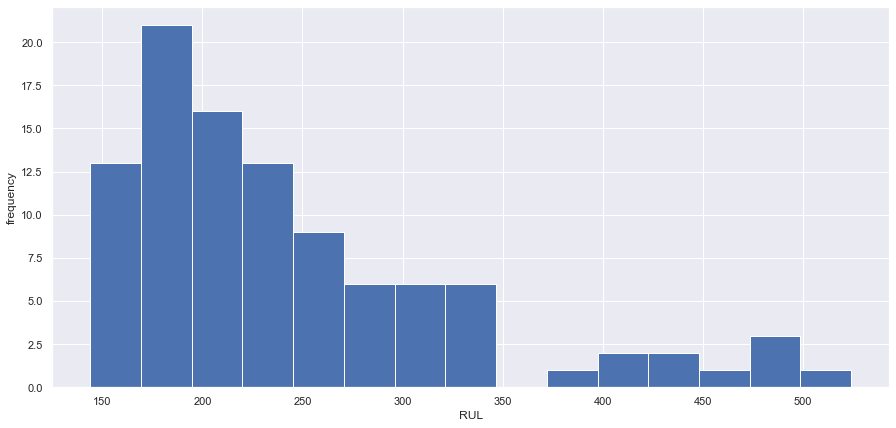

In [8]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').first().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel("RUL")
plt.ylabel("frequency")
plt.show()

We'll clip the RUL further down below, this plot just goes to show the distribution of linearly decreasing RUL and how skewed that distribution is.

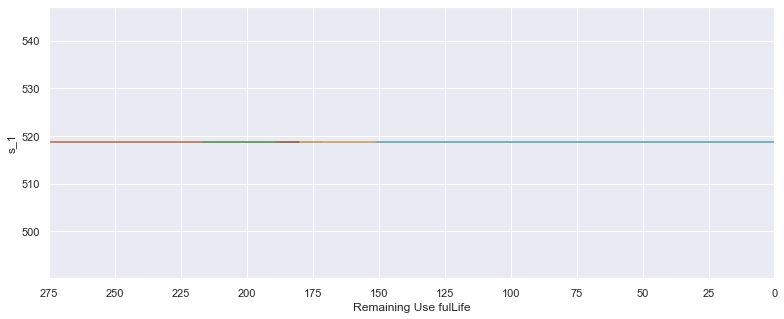

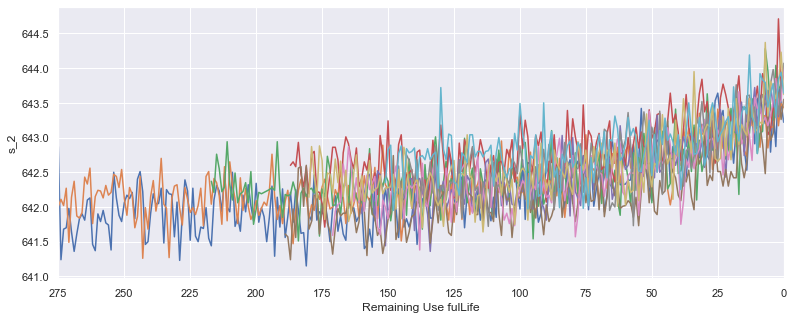

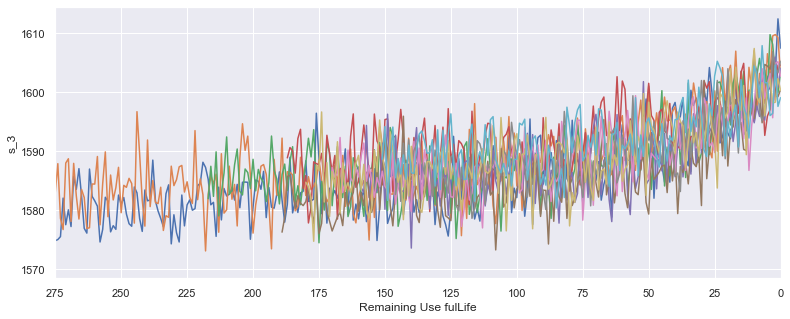

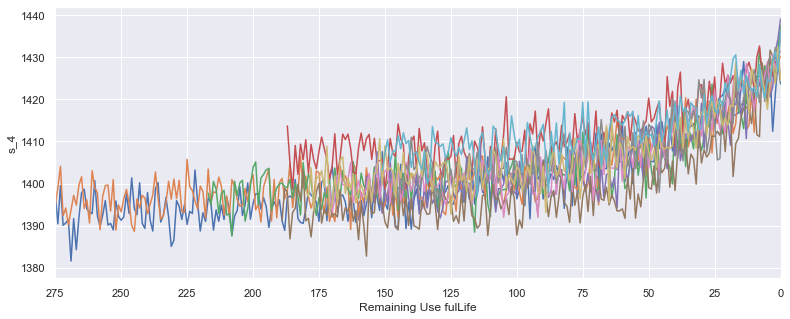

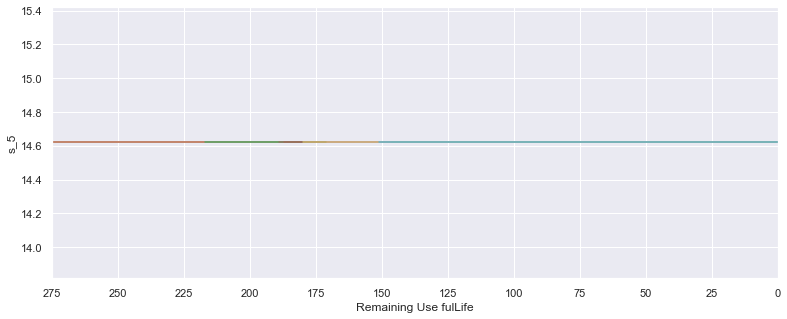

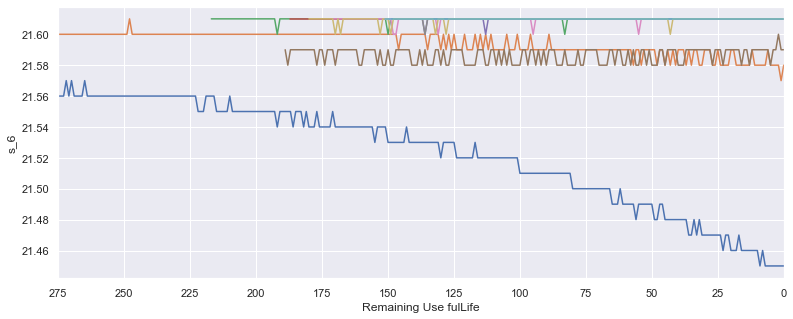

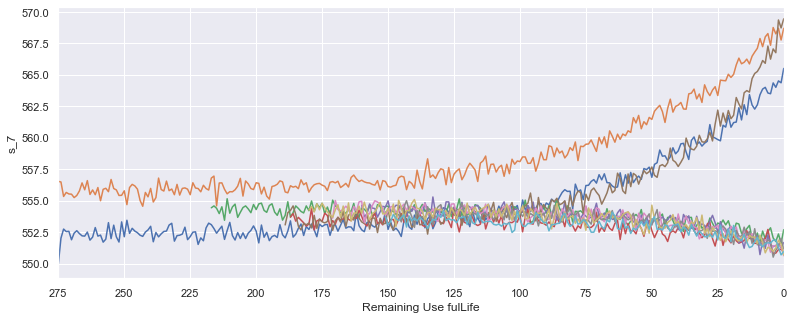

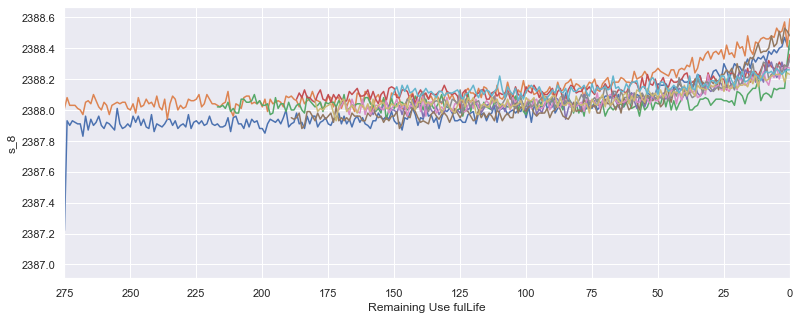

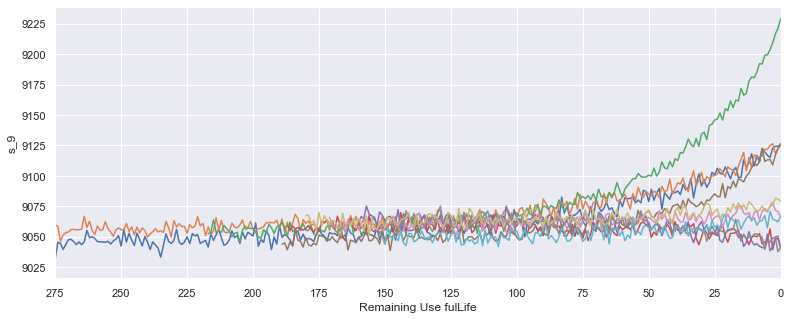

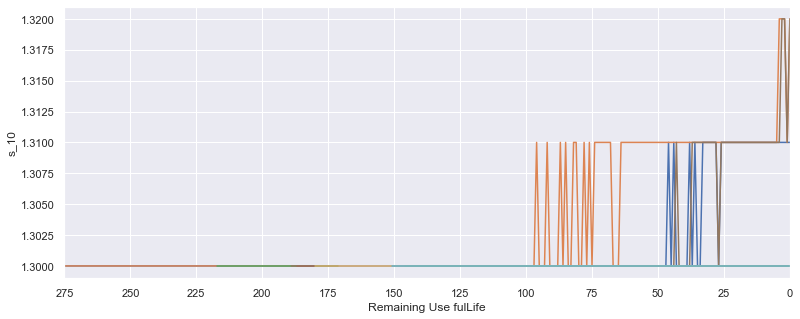

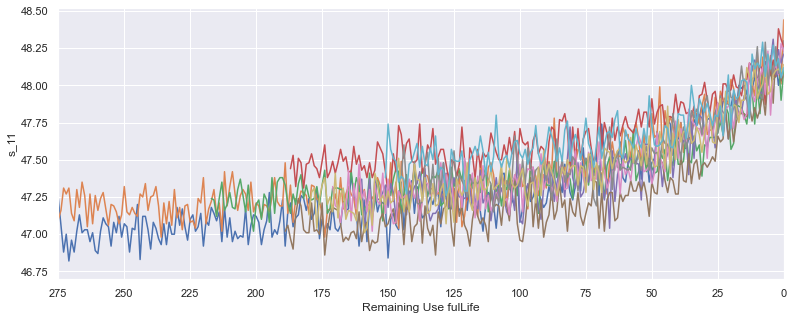

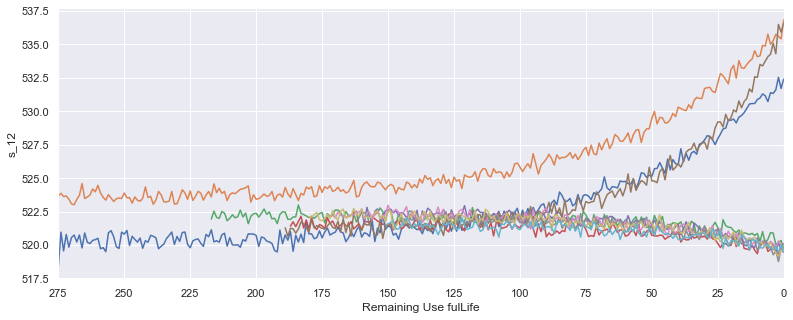

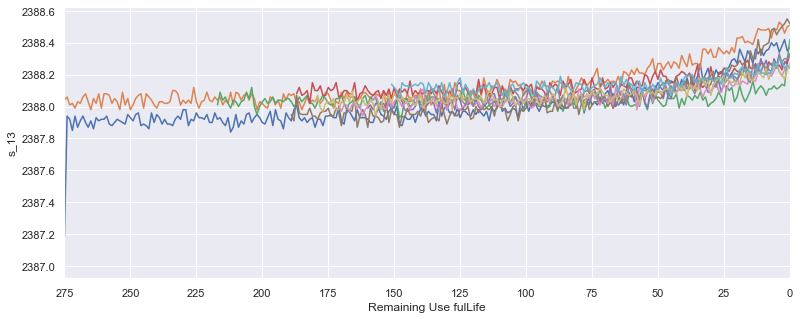

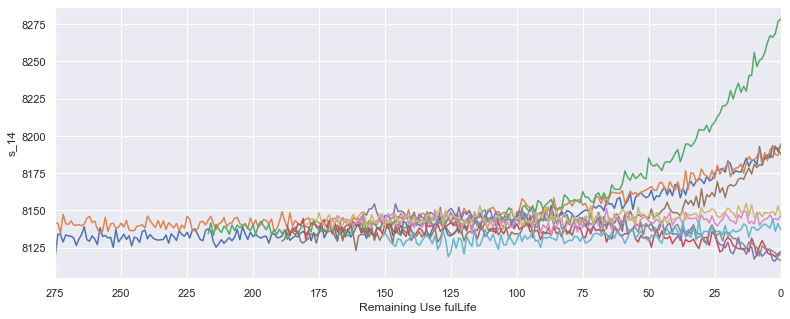

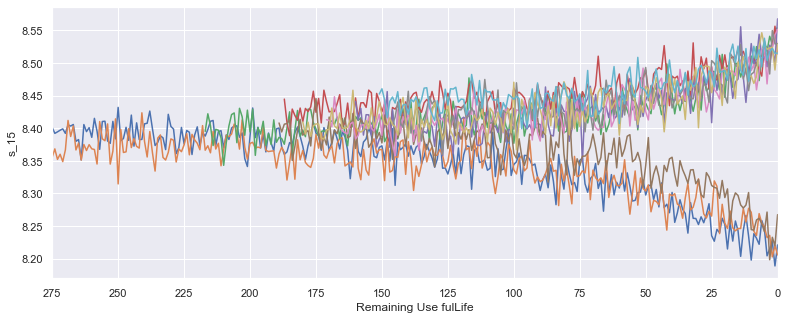

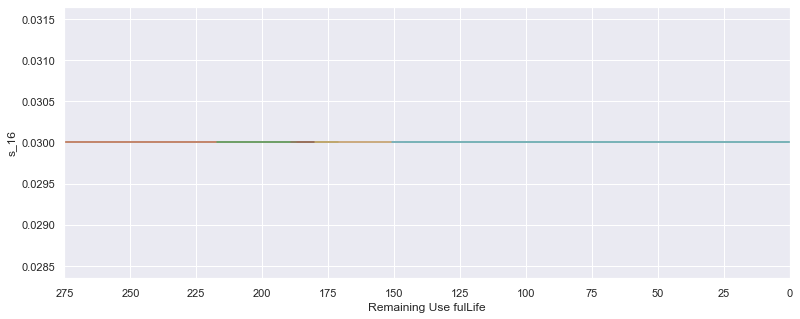

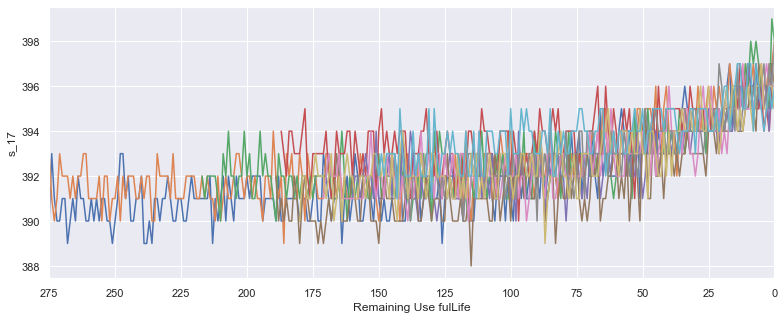

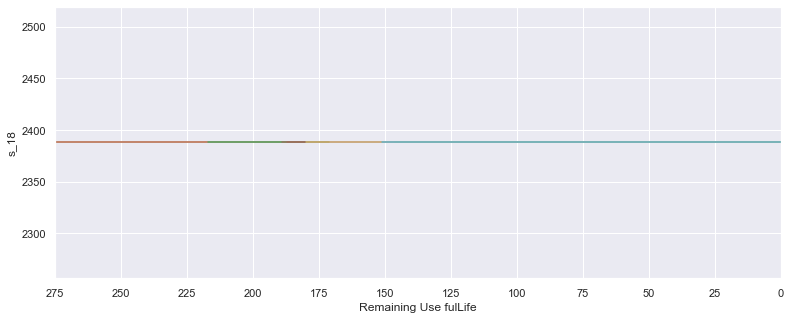

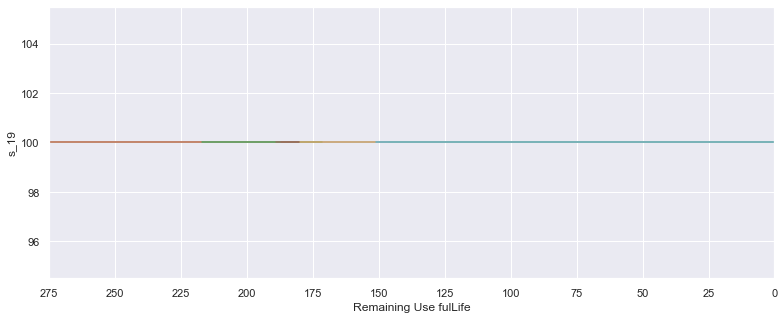

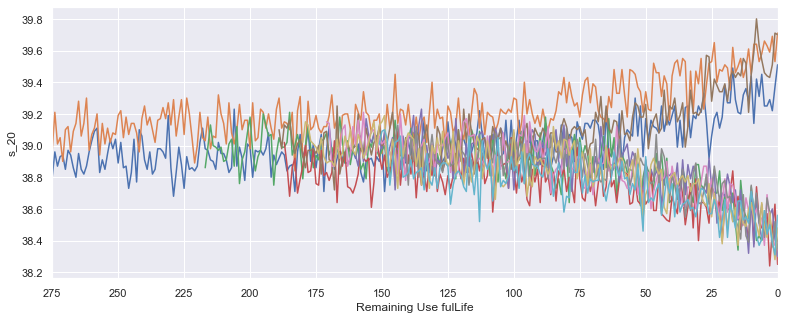

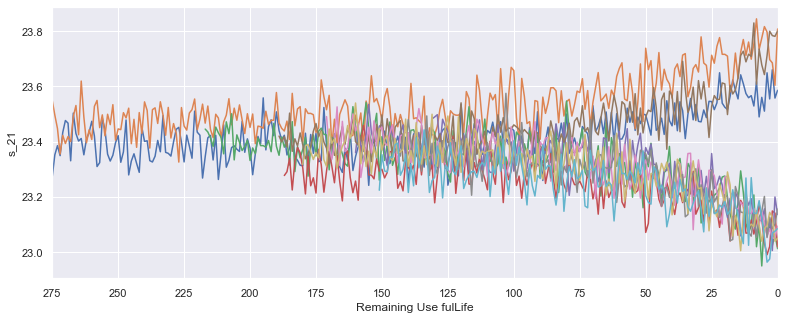

In [9]:
def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_nr'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, 
                     data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor in sensor_names:
    plot_signal(train, sensor)

We can reconfirm the exclusion of sensors 1, 5, 16, 18 and 19. Sensors 6 and 10 get the benefit of the doubt.  
Note sensors 7, 12, 15, 20 and 21, in which the two distinct faults seem visible

# Baseline model and initial RF

In [10]:
# prep data
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']  # s_6 and s_10 get the benefit of the doubt
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)  # apply RUL clipping from earlier posts

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [11]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [12]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:19.330134905061524, R2:0.7736110804777253
test set RMSE:22.319344484397757, R2:0.7092939799791873


In [13]:
# bare random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:5.9199939580022525, R2:0.9787661901585051
test set RMSE:21.05308450085165, R2:0.7413439613827657


The Random Forest outperformes the linear regression right off the bat. However, judging by the difference in train and test RMSE it is quite overfit

In [14]:
# perform some checks on tree layout
print(rf.estimators_[5].tree_.max_depth)  # check how many nodes in the longest path
rf.estimators_[5].tree_.n_node_samples    # check how many samples in the last nodes

33


array([15616, 11694,  7793, ...,     1,     1,     4], dtype=int64)

In [15]:
# crudely tweaked random forest
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.706704198492831, R2:0.8505294865338602
test set RMSE:20.994958823842456, R2:0.7427702419664686


By crudely tweaking the Random Forest we can reduce overfitting while gaining a slight performance increase. Fitting this same model without s_6 & s_10 performs worse, so those sensors are kept in. We'll use this model as a base for further improvements

# Visualize RF

In [16]:
from subprocess import call
from IPython.display import Image

In [17]:
# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
# https://stackoverflow.com/questions/14784405/how-to-set-the-output-size-in-graphviz-for-the-dot-format

def export_rf_visual(estimator, file_name, dpi):
    # create visualization of decesion tree
    tree = export_graphviz(estimator, 
       out_file=f'{file_name}.dot', 
       feature_names=X_train.columns, # column names
       filled=True,        
       special_characters=True, 
       rotate=True)

    # Convert to png using system command (requires Graphviz)
    # call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])  
    # due to the use of a virtual environment and some laptop settings I had to alter the command slightly
    call(['C:/miniconda3/envs/nasa_turbofan/Library/bin/graphviz/dot.exe', '-Tpng', 
          f'{file_name}.dot', '-o', f'{file_name}.png', f'-Gdpi={dpi}'])  # add/remove Gsize  , '-Gsize=52,128!'
    print(f'estimator succesfully exported to: {file_name}.png')
    return


# Export and display in jupyter notebook
file_name = 'C:/tmp/tree_FD003'
export_rf_visual(rf.estimators_[5], file_name, dpi=200)
Image(filename = f'{file_name}.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified

Note, this is just one tree from of the forest.  

There seem to be some nodes which result in very inaccurate predictions (mse > 500). There are some parts where sensors 9 and 14 show up a lot as splitting criterion, while their ability to distinguish between faults was mediocre at best. Let's fit a RF without those sensors to see if performance improves.

In [ ]:
drop_sensors = ['s_1','s_5', 's_9', 's_14', 's_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_10',
       's_11', 's_12', 's_13', 's_15', 's_17', 's_20', 's_21']

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)

X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [ ]:
# crudely tweaked random forest
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

Unfortunately performance becomes quite a bit worse, so we'll keep sensor 9 and 14 in.

In [ ]:
drop_sensors = ['s_1','s_5', 's_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)

X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

# A word on Feature engineering
There aren't a lot of possibilities for feature engineering for this particular dataset - algorithm combination. Random Forests naturally excell at ... are invariant to scaling and polynomials. Since all features are numeric already there isn't much more we can do besides smoothing the data

### Apply smoothing
In an atempt to make it easier to distinguish between faults

In [ ]:
def smooth(df, sensors, n_samples):
    # first, take the rolling mean for
    df[sensors] = df.groupby('unit_nr')[sensors].rolling(n_samples).mean().reset_index(drop=True)
    
    # second, drop introduced Na's
    # https://stackoverflow.com/questions/31226142/python-pandas-delete-the-first-row-by-group
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples+1] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    # third, update column names
    df.columns = df.columns.str.replace('s_', 'sma_')
    smooth_sensors = [string.replace('s_', 'sma_') for string in sensors]  # create seperate list for later use   
    return df, smooth_sensors

In [ ]:
train_smooth = train.copy()
train_smooth.drop(drop_sensors+setting_names, axis=1, inplace=True)
train_smooth, smooth_sensors = smooth(train_smooth, remaining_sensors, 15)

In [ ]:
plot_signal(train_smooth, 'sma_7')

Results look good, let's apply smoothing to the test set too, retrain and evaluate

In [ ]:
test_smooth = test.copy()
test_smooth.drop(drop_sensors+setting_names, axis=1, inplace=True)
test_smooth, _ = smooth(test_smooth, remaining_sensors, 15)

In [ ]:
X_train_smooth = train_smooth[smooth_sensors]
y_train_clipped_smooth = train_smooth['RUL'].clip(upper=125)  
# we haven't really smoothed the RUL values, but it helps to distinguish it from the original

X_test_smooth = test_smooth.groupby('unit_nr').last().reset_index().drop(index_names, axis=1)

In [ ]:
# crudely tweaked random forest with smoothed sensors
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train_smooth, y_train_clipped_smooth)

# predict and evaluate
y_hat_train = rf.predict(X_train_smooth)
evaluate(y_train_clipped_smooth, y_hat_train, 'train')

y_hat_test = rf.predict(X_test_smooth)
evaluate(y_test, y_hat_test)

unfortunately smoothing doesn't improve the RMSE in this case

# Hyper parameters

In [ ]:
# first retrain the model to get back to our best effort so far


# crudely tweaked random forest
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

### what parameters can we tune?

In [ ]:
rf.get_params()

The biggest challenge in fitting Random Forests is overfitting, the below parameters help reduce overfitting and generating overall better performing models.  
- max_depth: determines the depth of the tree  
- min_samples_leaf: determines the minimum samples required in leaf nodes  
- ccp_alpha: cost complexity parameter alpha prunes leaves after fitting, impacting the max_depth of the tree, so it could be interesting to set max_depth free and let ccp_alpha determine tree depth  
- min_impurity_decrease: determines if the decrease in impurity (error) is big enough to warrant a split

max_depth and min_samples_leaf should be quite self explanatory, but ccp_alhpa and min_impurity_decrease need a bit more exploration.

### ccp alpha
ccp stands for cost complexity pruning, basically it calculates a value (alpha) which indicates the complexity of the path from the first node to the other nodes. Lower values of alpha indicate higher complexity. By removing nodes for which alpha lies below a certain threshold you prune the tree of 'overfit' nodes. Below we'll investigate suitable thresholds for alpha. You can read more at  https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [ ]:
# get ccp_alphas
path = rf.estimators_[5].cost_complexity_pruning_path(X_train, y_train_clipped)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(13,5))
# the root node of the tree (indexed with [:-1]) is left out of the analysis, as without it there wouldn't be a tree
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
# zoom in
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(ccp_alphas[:-10], impurities[:-10], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Effective alpha's below 2 have the highest cost complexity, but leaf impurity is also lowered by an additional 50 points (~7 train RMSE). This seems like a suitable range to use for hyperparameter tuning.

### impurity decrease
The impurity decrease indicates how much the error decreases after a split. This decrease is weighted for the amount of samples in the parent node and child nodes/leaves. Setting a value for min_impurity_decrease effectively reverses a split if the gained impurity decrease is lower than the set value. Below we'll investigate suitable values for min_impurity_decrease. You can read more at https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
import sklearn
help(sklearn.tree._tree.Tree)  # we need to get certain parameters from a single decision tree to calculate impurity decrease

In [ ]:
rf_dict = {
    'id_node': list(range(rf.estimators_[5].tree_.node_count)),
    'impurity': rf.estimators_[5].tree_.impurity,
    'samples': rf.estimators_[5].tree_.n_node_samples,
    'id_left_child': rf.estimators_[5].tree_.children_left,
    'id_right_child': rf.estimators_[5].tree_.children_right
}

impurity_df = pd.DataFrame(rf_dict)
print(impurity_df.shape)
impurity_df.head(10)

In [ ]:
# check if all leaf nodes have value -1 for left and right child nodes
impurity_df.loc[impurity_df['id_left_child'] == -1, 'id_right_child'].unique()
impurity_df.loc[impurity_df['id_right_child'] == -1, 'id_left_child'].unique()  # yes they do

In [ ]:
impurity_df['impurity_decrease'] = np.nan
samples_total = rf.estimators_[5].tree_.node_count

for idx in impurity_df.index[1:]:  # skip the first node, there aren't any splits prior to it
    if impurity_df.iloc[idx]['id_left_child'] == -1:
        continue  # we can't calculeate impurity decrease for leave nodes, as they no longer split
    else:
        impurity_P, samples_P = impurity_df.iloc[idx][['impurity', 'samples']]
        id_L, id_R = impurity_df.iloc[idx][['id_left_child', 'id_right_child']].astype(int)
        impurity_L, samples_L = impurity_df.iloc[id_L][['impurity', 'samples']]
        impurity_R, samples_R = impurity_df.iloc[id_R][['impurity', 'samples']]
        
        impurity_decrease = samples_P / samples_total * (
            impurity_P - samples_R / samples_P * impurity_R - 
            samples_L / samples_P * impurity_L
            )
        impurity_df.at[idx, 'impurity_decrease'] = impurity_decrease

In [ ]:
impurity_df.head()

In [ ]:
impurity_df['impurity_decrease'].plot(kind='hist', bins=50)

In [ ]:
impurity_df['impurity_decrease'].describe()

In [ ]:
impurity_df.loc[impurity_df['impurity_decrease'] < 14.59, 'impurity_decrease'].plot(kind='hist', bins=15)

The 25th percentile seems like a nice upper-bound for the min_impurity_decrease parameter

# Gridsearch

using randomized gridsearch as the amount of parameters is rather large. random search as implemented below provides a > 95% of finding hyper parameters within the best %5 of solutions. [Zheng, Alice. Evaluating Machine Learning Models. O’Reilly Media, Inc. 2015]

In addition I keep the number of trees small, to keep the training times low  
The combination of random search and a small number of trees alow for a relatively fast search. I executed the search a couple of times and chose the best performing settings

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

In [ ]:
max_depth = [None] + list(range(3, 34, 3))  # max depth of the first RF was 33, I don't expect we need bigger depth
min_samples_leaf = list(range(1, 102, 10))  # with crude tweaking we set this to 50, for grid search I'll allow double
min_impurity_decrease = list(np.arange(0,147)/10)  
ccp_alpha = list(np.round(np.linspace(0, 2, 81), decimals=3))  

parameters = {
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,
    'ccp_alpha': ccp_alpha
}

In [ ]:
tuning_options = len(max_depth) * len(min_samples_leaf) * len(min_impurity_decrease) * len(ccp_alpha)
print(tuning_options)

In [ ]:
ITERATIONS = 300

rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
gkf = GroupKFold(n_splits=3)


regressor = RandomizedSearchCV(rf, 
                               parameters, 
                               cv = gkf.split(train, groups=train['unit_nr']),
                               verbose=2, 
                               error_score='raise',
                               n_iter=ITERATIONS, 
                               n_jobs=-2,
                               # scoring https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                               scoring= 'neg_root_mean_squared_error')  
regressor.fit(X_train, y_train_clipped)

In [ ]:
results = pd.DataFrame(regressor.cv_results_)
columns = ['param_min_samples_leaf', 'param_min_impurity_decrease', 'param_max_depth', 'param_ccp_alpha', 
           'mean_test_score', 'std_test_score', 'rank_test_score']
results[columns].sort_values('mean_test_score', ascending=False)

Unfortunately results aren't reproducible, meaning restarting the kernel and running the notebook again doesn't produce the same results. Something I will try to tackle in the next analysis

In [ ]:
print(regressor.best_params_)
print(regressor.best_score_)


# best try
# {'min_samples_leaf': 11, 'min_impurity_decrease': 0.0, 'max_depth': 15, 'ccp_alpha': 0.125}
# -16.577118899026214

# Final model

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42,
                           min_samples_leaf=11, min_impurity_decrease=0.0, 
                           max_depth=15, ccp_alpha=0.125)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

The test RMSE of 20.612 is a a (22.319 - 20.612) / 22.319 * 100 = 7.65% improvement over our baseline model.